##Import various python functions and modules that we need.

In [2]:
from pandas import DataFrame
from IPython.display import FileLink

##Pylab namespace and inline plots. Import Rmagic.

In [3]:
%matplotlib inline
%load_ext rpy2.ipython

##Import R libraries we'll use.

In [4]:
%%R
library(phyloseq)
library(ggplot2)
library(foreach)
library(doParallel)
library(gridExtra)
library(vegan)
library(plyr)
library(RColorBrewer)
library(stats)
library(dplyr)

/opt/anaconda2/lib/python2.7/site-packages/rpy2/rinterface/__init__.py:186: RRuntimeWarning: foreach: simple, scalable parallel programming from Revolution Analytics
Use Revolution R for scalability, fault tolerance and more.
http://www.revolutionanalytics.com

  warnings.warn(x, RRuntimeWarning)
/opt/anaconda2/lib/python2.7/site-packages/rpy2/rinterface/__init__.py:186: RRuntimeWarning: Loading required package: iterators

  warnings.warn(x, RRuntimeWarning)
/opt/anaconda2/lib/python2.7/site-packages/rpy2/rinterface/__init__.py:186: RRuntimeWarning: Loading required package: parallel

  warnings.warn(x, RRuntimeWarning)
/opt/anaconda2/lib/python2.7/site-packages/rpy2/rinterface/__init__.py:186: RRuntimeWarning: Loading required package: permute

  warnings.warn(x, RRuntimeWarning)
/opt/anaconda2/lib/python2.7/site-packages/rpy2/rinterface/__init__.py:186: RRuntimeWarning: Loading required package: lattice

  warnings.warn(x, RRuntimeWarning)
/opt/anaconda2/lib/python2.7/site-packages/

##Import data into R. Prune to relevant samples (PS, non-bulk). Get rid of OTUs not observed in at least 25% of samples)

In [5]:
%%R
physeq = import_biom("data/SIP_Bulk_otu_table_wtax.biom")
print(physeq)
sample.data = import_qiime_sample_data("data/Metadata_fungi.txt")
physeq = merge_phyloseq(physeq,sample.data)
print(physeq)
physeq.md = sample_data(physeq)
physeq.fungi = prune_samples((physeq.md$Treatment %in% c("12CCPS","13CCPS"))& 
                             (physeq.md$SampleID != c("D312.6"))& (physeq.md$Mock_Comm != "bulk"),  physeq)
physeq.fungi.prune = prune_samples(sample_sums(physeq.fungi) > 5360, physeq.fungi)
print (physeq.fungi.prune)
physeq.fungi.snorm = transform_sample_counts(physeq.fungi.prune, function(x) x/sum(x))
physeq.fungi.thresh = filter_taxa(physeq.fungi.snorm, function(x) sum(x > 0) / length(x) > (0.25), TRUE)
#physeq.fungi.thresh.min = filter_taxa(physeq.fungi.thresh, function(x) sum(x) > 5000, TRUE)
#physeq.fungi.thresh = filter_taxa(physeq.SIP.snorm, function(x) sum(x > 0) > (0.25 * length(x)), TRUE)
print(physeq.fungi.thresh)

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 1905 taxa and 181 samples ]
tax_table()   Taxonomy Table:    [ 1905 taxa by 7 taxonomic ranks ]
phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 1905 taxa and 181 samples ]
sample_data() Sample Data:       [ 181 samples by 9 sample variables ]
tax_table()   Taxonomy Table:    [ 1905 taxa by 7 taxonomic ranks ]
phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 1905 taxa and 162 samples ]
sample_data() Sample Data:       [ 162 samples by 9 sample variables ]
tax_table()   Taxonomy Table:    [ 1905 taxa by 7 taxonomic ranks ]
phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 564 taxa and 162 samples ]
sample_data() Sample Data:       [ 162 samples by 9 sample variables ]
tax_table()   Taxonomy Table:    [ 564 taxa by 7 taxonomic ranks ]


In [6]:
%%R
df = psmelt(physeq.fungi.prune)

In [7]:
%%R
head(df)

        OTU   Sample Abundance SampleID Primers       i2       i1 Day  Density
52    OTU.1  D1413.9     33580  D1413.9      30 cgtgagtg actcactg  14 1.735145
43    OTU.1 D1413.10     33113 D1413.10      31 ggatatct actcactg  14 1.729681
93900 OTU.2 D3013.10     30125 D3013.10      91 tagcgagt tatagcga  30 1.731866
122   OTU.1 D1413.11     25269 D1413.11      32 gacaccgt actcactg  14 1.725310
111   OTU.1  D1413.6     23840  D1413.6      27 tagcgagt actcactg  14 1.751536
12    OTU.1 D3013.10     23307 D3013.10      91 tagcgagt tatagcga  30 1.731866
      Treatment Mock_Comm RNA_DNA    Rank1         Rank2              Rank3
52       13CCPS         N     DNA k__Fungi p__Ascomycota  c__Incertae sedis
43       13CCPS         N     DNA k__Fungi p__Ascomycota  c__Incertae sedis
93900    13CCPS         N     DNA k__Fungi p__Ascomycota c__Sordariomycetes
122      13CCPS         N     DNA k__Fungi p__Ascomycota  c__Incertae sedis
111      13CCPS         N     DNA k__Fungi p__Ascomycota  c__Incert

In [8]:
%%R
a %>%
summarise(tab = sum(Abundance)) %>%
summarise(avg = mean(tab), std = sd(tab))


Error in eval(expr, envir, enclos) : object 'a' not found


/opt/anaconda2/lib/python2.7/site-packages/rpy2/rinterface/__init__.py:186: RRuntimeWarning: Error in eval(expr, envir, enclos) : object 'a' not found

  warnings.warn(x, RRuntimeWarning)


In [9]:
%%R
a$Gradient = sub("^(.*)[.].*", "\\1", a$Sample)



Error in sub("^(.*)[.].*", "\\1", a$Sample) : object 'a' not found


/opt/anaconda2/lib/python2.7/site-packages/rpy2/rinterface/__init__.py:186: RRuntimeWarning: Error in sub("^(.*)[.].*", "\\1", a$Sample) : object 'a' not found

  warnings.warn(x, RRuntimeWarning)


In [10]:
%%R
a %>% group_by(Gradient) %>% 
select(Gradient, Abundance) %>%
summarise(totab = sum(Abundance))# %>%
#summarise(avg = mean(totab), std = sd(totab))


Error in eval(expr, envir, enclos) : object 'a' not found


In [11]:
%%R
a %>% group_by(Gradient) %>% 
select(Gradient) %>%
summarise(sumsample = n())# %>%
#summarise(avg = mean(totab), std = sd(totab))


Error in eval(expr, envir, enclos) : object 'a' not found


### Calculate Bray-Curtis distances between samples.

In [12]:
%%R
iDist <- distance(physeq.fungi.thresh, method = "bray")

### Plotting Bray-Curtis distance vs. density

###Ordinate using weighted unifrac distnaces with NMDS.

Run 0 stress 0.09366946 
Run 1 stress 0.09351724 
... New best solution
... Procrustes: rmse 0.004947124  max resid 0.05729914 
Run 2 stress 0.09352068 
... Procrustes: rmse 0.001146846  max resid 0.008017827 
... Similar to previous best
Run 3 stress 0.09367252 
... Procrustes: rmse 0.00494105  max resid 0.05732181 
Run 4 stress 0.09351723 
... New best solution
... Procrustes: rmse 9.349997e-05  max resid 0.0008830907 
... Similar to previous best
Run 5 stress 0.1055827 
Run 6 stress 0.1053007 
Run 7 stress 0.09366955 
... Procrustes: rmse 0.005074742  max resid 0.05705844 
Run 8 stress 0.105559 
Run 9 stress 0.09366801 
... Procrustes: rmse 0.004952754  max resid 0.05732346 
Run 10 stress 0.0935171 
... New best solution
... Procrustes: rmse 7.253957e-05  max resid 0.0007220946 
... Similar to previous best
Run 11 stress 0.09351707 
... New best solution
... Procrustes: rmse 1.349475e-05  max resid 0.0001053907 
... Similar to previous best
Run 12 stress 0.09351992 
... Procrustes: 

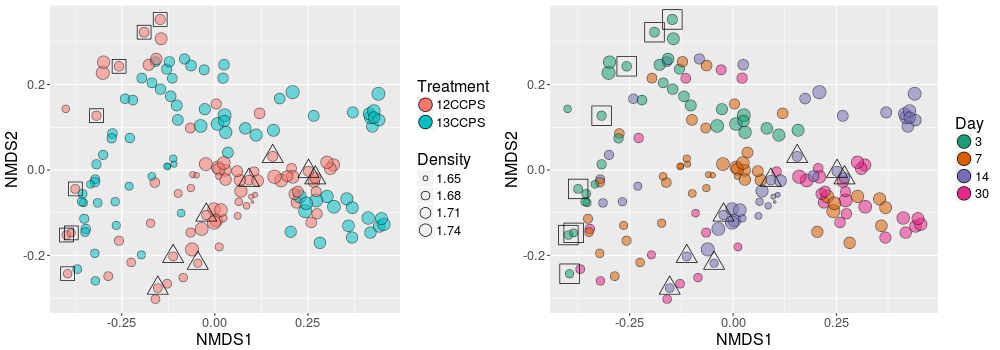

In [13]:
%%R -w 1000 -h 350
nmds = ordinate(physeq.fungi.thresh, 
                method = "NMDS", 
                distance = iDist)
p.nmds = plot_ordination(physeq.fungi.thresh, nmds, justDF = TRUE)
#print(p)

asNumeric = function(x) { as.numeric(as.character(x)) }

sub = p.nmds %>% filter(Primers%in% c(57,58,59,60,61,62,63,64))
sub2 = p.nmds %>% filter(Primers%in% c(11,12,13,14,15,16,17,18))

p1 = ggplot(p.nmds, aes(x = NMDS1, y = NMDS2)) +  
        geom_point(aes(fill = Treatment, size = asNumeric(Density), alpha = 0.85), pch=21) +
        guides(alpha = FALSE, fill=guide_legend(override.aes=list(size=6))) + labs(size = "Density") +
        theme(text = element_text(size=16)) 
p1 = p1 + geom_point(data = sub, aes(x= NMDS1, y = NMDS2), shape = 22, size = 7 ) 
p1 = p1 + geom_point(data = sub2, aes(x= NMDS1, y = NMDS2), shape = 24, size = 7 ) 


      

p2 = ggplot(p.nmds, aes(x = NMDS1, y = NMDS2)) +  
        geom_point(aes(fill = factor(asNumeric(Day)), size = asNumeric(Density), alpha = 0.95), pch=21) +
        guides(alpha = FALSE, size = FALSE, fill=guide_legend(override.aes=list(size=6)))+
        scale_fill_brewer("Day", palette = "Dark2") + theme(text = element_text(size=16)) 
p2 = p2 + geom_point(data = sub, aes(x= NMDS1, y = NMDS2), shape = 22, size = 10 ) 
p2 = p2 + geom_point(data = sub2, aes(x= NMDS1, y = NMDS2), shape = 24, size = 7 ) 



p.combined = grid.arrange(p1, p2, ncol=2)
print(p.combined)

In [14]:
%%R -w 1000 -h 350
pdf("figs/full_ordination.pdf", width = 12, height = 5)
grid.arrange(p1, p2, ncol=2)
dev.off()


Error in pdf("figs/full_ordination.pdf", width = 12, height = 5) : 
  cannot open file 'figs/full_ordination.pdf'


/opt/anaconda2/lib/python2.7/site-packages/rpy2/rinterface/__init__.py:186: RRuntimeWarning: Error in pdf("figs/full_ordination.pdf", width = 12, height = 5) : 
  cannot open file 'figs/full_ordination.pdf'

  warnings.warn(x, RRuntimeWarning)


In [15]:
FileLink("figs/full_ordination.pdf")

/home/chantal/FungalSIP/figs/full_ordination.pdf

###...and the MDS figure (PC2 v Density).

TableGrob (1 x 2) "arrange": 2 grobs
  z     cells    name           grob
1 1 (1-1,1-1) arrange gtable[layout]
2 2 (1-1,2-2) arrange gtable[layout]


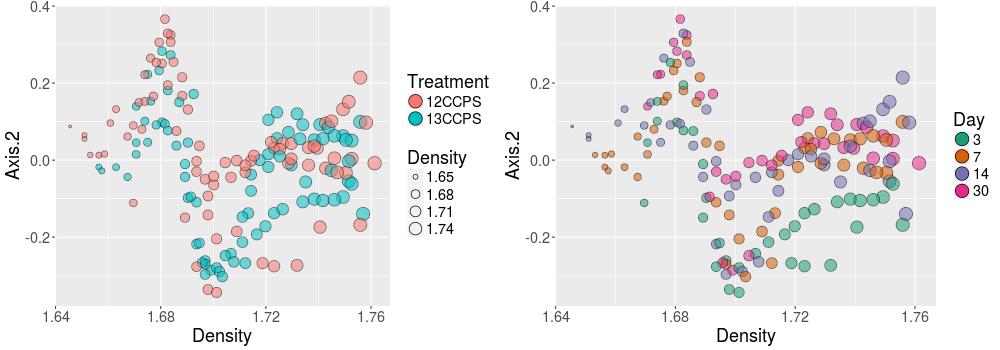

In [16]:
%%R -w 1000 -h 350
mds = ordinate(physeq.fungi.thresh, 
                method = "MDS", 
                distance = iDist)
p.mds = plot_ordination(physeq.fungi.thresh, mds, justDF = TRUE)

asNumeric = function(x) { as.numeric(as.character(x)) }

p1.mds = ggplot(p.mds, aes(x = asNumeric(Density), y = Axis.2)) +  
        geom_point(aes(fill = Treatment, size = asNumeric(Density), alpha = 0.85), pch=21) +
        guides(alpha = FALSE, fill=guide_legend(override.aes=list(size=6))) + labs(x = "Density", size = "Density")+
        theme(text = element_text(size=18)) 

p2.mds = ggplot(p.mds, aes(x = asNumeric(Density), y = Axis.2)) + labs(x = "Density") +
        geom_point(aes(fill = factor(asNumeric(Day)), size = asNumeric(Density), alpha = 0.95), pch=21) +
        guides(alpha = FALSE, size = FALSE, fill=guide_legend(override.aes=list(size=6)))+ 
        scale_fill_brewer("Day", palette = "Dark2") + theme(text = element_text(size=18)) 

p.combined.mds = grid.arrange(p1.mds, p2.mds, ncol=2)
print(p.combined.mds)

In [17]:
%%R -w 1000 -h 350
pdf("figs/full_ordination_density.pdf", width = 12, height = 5)
grid.arrange(p1.mds, p2.mds, ncol=2)
dev.off()


Error in pdf("figs/full_ordination_density.pdf", width = 12, height = 5) : 
  cannot open file 'figs/full_ordination_density.pdf'


/opt/anaconda2/lib/python2.7/site-packages/rpy2/rinterface/__init__.py:186: RRuntimeWarning: Error in pdf("figs/full_ordination_density.pdf", width = 12, height = 5) : 
  cannot open file 'figs/full_ordination_density.pdf'

  warnings.warn(x, RRuntimeWarning)


In [18]:
FileLink("figs/full_ordination_density.pdf")

/home/chantal/FungalSIP/figs/full_ordination_density.pdf

TableGrob (1 x 2) "arrange": 2 grobs
  z     cells    name           grob
1 1 (1-1,1-1) arrange gtable[layout]
2 2 (1-1,2-2) arrange gtable[layout]


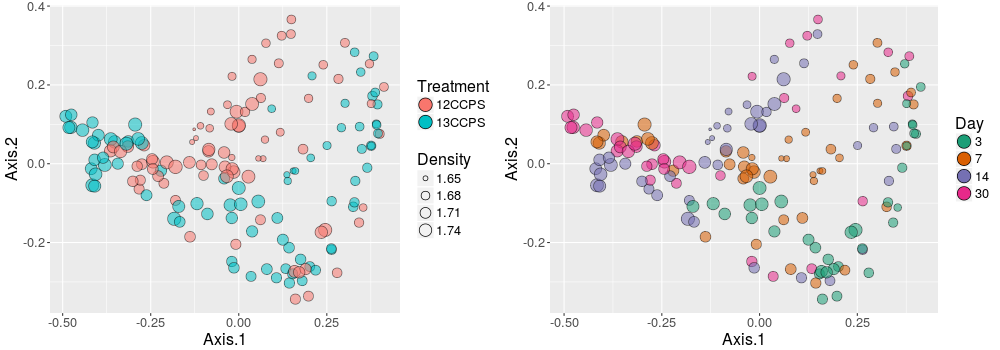

In [19]:
%%R -w 1000 -h 350
pcoa = ordinate(physeq.fungi.thresh, 
                method = "PCoA", 
                distance = "bray")
p.pcoa = plot_ordination(physeq.fungi.thresh, pcoa, justDF = TRUE)
#print(p.pcoa)

asNumeric = function(x) { as.numeric(as.character(x)) }

p1 = ggplot(p.pcoa, aes(x = Axis.1, y = Axis.2)) +  
        geom_point(aes(fill = Treatment, size = asNumeric(Density), alpha = 0.85), pch=21) +
        guides(alpha = FALSE, fill=guide_legend(override.aes=list(size=6))) + labs(size = "Density") +
        theme(text = element_text(size=16)) 

p2 = ggplot(p.pcoa, aes(x = Axis.1, y = Axis.2)) +  
        geom_point(aes(fill = factor(asNumeric(Day)), size = asNumeric(Density), alpha = 0.95), pch=21) +
        guides(alpha = FALSE, size = FALSE, fill=guide_legend(override.aes=list(size=6)))+ 
        scale_fill_brewer("Day", palette = "Dark2") + theme(text = element_text(size=16)) 

p.combined = grid.arrange(p1, p2, ncol=2)
print(p.combined)


In [20]:
%%R
registerDoParallel(cores=20)

md = sample_data(physeq.fungi.thresh)
days = unique(md$Day)
days = days[order(days)]

species.scores = function(x, y) {
    # x is the site scores data frame
    # y is the corresponding phyloseq object
    
    site.scores = x[,c(1,2)]
    
    if( setequal(row.names(site.scores), row.names(t(otu_table(y)))) ){
        w = wascores(site.scores,t(otu_table(y)),expand=TRUE)
    } else {
        print("Indices don't match")
        print(setdiff(row.names(site.scores), row.names(t(otu_table(y)))))
    }                                    

    otu.scores = data.frame(w)
    otu.scores$OTU = rownames(otu.scores)
    
    supp = tax_table(y)
    
    if( setequal(row.names(otu.scores), row.names(supp)) ){
        otu.scores.wtax = data.frame(otu.scores, supp)
    } else {
        print("Indices not the same.")
        print(setdiff(row.names(w), row.names(supp)))
    }
    
    return(otu.scores.wtax)
    
}

ord = function(x) {
    
    ps = prune_samples(md$Day == x, physeq.fungi.thresh)
    
    pcoa = ordinate(ps, 
                method = "PCoA", 
                distance = "bray")
    
    df.sites = plot_ordination(ps, pcoa, justDF = TRUE)
    df.sites$type = "sites"
    
    df.otus = species.scores(df.sites, ps)
    df.otus$Day = x
    df.otus$type = "otus"
    
    df = rbind.fill(df.otus, df.sites)
    
    return(df)
}

df.plot = ldply(days, ord)

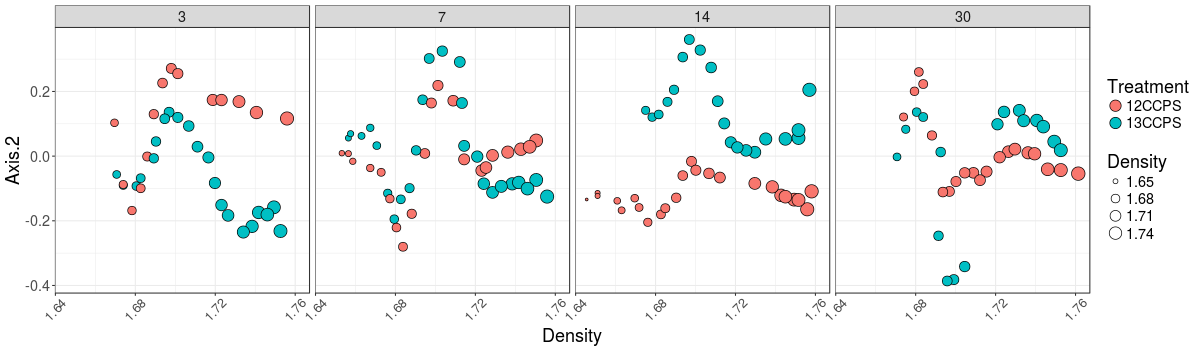

In [21]:
%%R -w 1200 -h 350

df = subset(df.plot, type == "sites")

asNum = function(x) as.numeric(as.character(x))

p = ggplot(df, aes(x =Density, y = Axis.2, size = Density, fill = Treatment))
#p = ggplot(df, aes(x = NMDS1, y = NMDS2, size = Density, fill = Treatment))

p = p + facet_wrap(~Day, nrow=1)

p = p + geom_point(shape = 21)

p = p + theme_bw() + theme(text = element_text(size=18), axis.text.x  = element_text(angle=45, vjust=0.5, size=13)) +
    guides(fill = guide_legend(override.aes = list(size=5)))
    
p

In [22]:
%%R
registerDoParallel(cores=20)

md = sample_data(physeq.fungi.thresh)
days = unique(md$Day)
days = days[order(days)]

species.scores = function(x, y) {
    # x is the site scores data frame
    # y is the corresponding phyloseq object
    
    site.scores = x[,c(1,2)]
    
    if( setequal(row.names(site.scores), row.names(t(otu_table(y)))) ){
        w = wascores(site.scores,t(otu_table(y)),expand=TRUE)
    } else {
        print("Indices don't match")
        print(setdiff(row.names(site.scores), row.names(t(otu_table(y)))))
    }                                    

    otu.scores = data.frame(w)
    otu.scores$OTU = rownames(otu.scores)
    
    supp = tax_table(y)
    
    if( setequal(row.names(otu.scores), row.names(supp)) ){
        otu.scores.wtax = data.frame(otu.scores, supp)
    } else {
        print("Indices not the same.")
        print(setdiff(row.names(w), row.names(supp)))
    }
    
    return(otu.scores.wtax)
    
}

ord = function(x) {
    
    ps = prune_samples(md$Day == x, physeq.fungi.thresh)
    
    pcoa = ordinate(ps, 
                method = "NMDS", 
                distance = "bray")
    
    df.sites = plot_ordination(ps, pcoa, justDF = TRUE)
    df.sites$type = "sites"
    
    df.otus = species.scores(df.sites, ps)
    df.otus$Day = x
    df.otus$type = "otus"
    
    df = rbind.fill(df.otus, df.sites)
    
    return(df)
}

df.plot = ldply(days, ord)

Run 0 stress 0.08671684 
Run 1 stress 0.1276803 
Run 2 stress 0.1052803 
Run 3 stress 0.1119621 
Run 4 stress 0.08687018 
... Procrustes: rmse 0.006838584  max resid 0.0328864 
Run 5 stress 0.1062242 
Run 6 stress 0.1052803 
Run 7 stress 0.1542577 
Run 8 stress 0.08671682 
... New best solution
... Procrustes: rmse 5.13777e-05  max resid 0.0002702834 
... Similar to previous best
Run 9 stress 0.08671684 
... Procrustes: rmse 3.606004e-05  max resid 0.0001636426 
... Similar to previous best
Run 10 stress 0.08687015 
... Procrustes: rmse 0.006829692  max resid 0.03286886 
Run 11 stress 0.111786 
Run 12 stress 0.1375618 
Run 13 stress 0.1666665 
Run 14 stress 0.08687015 
... Procrustes: rmse 0.006831551  max resid 0.0328737 
Run 15 stress 0.1249481 
Run 16 stress 0.1062243 
Run 17 stress 0.1190256 
Run 18 stress 0.1248393 
Run 19 stress 0.1190193 
Run 20 stress 0.1248391 
*** Solution reached
Run 0 stress 0.05909648 
Run 1 stress 0.1358137 
Run 2 stress 0.1370686 
Run 3 stress 0.1268289 

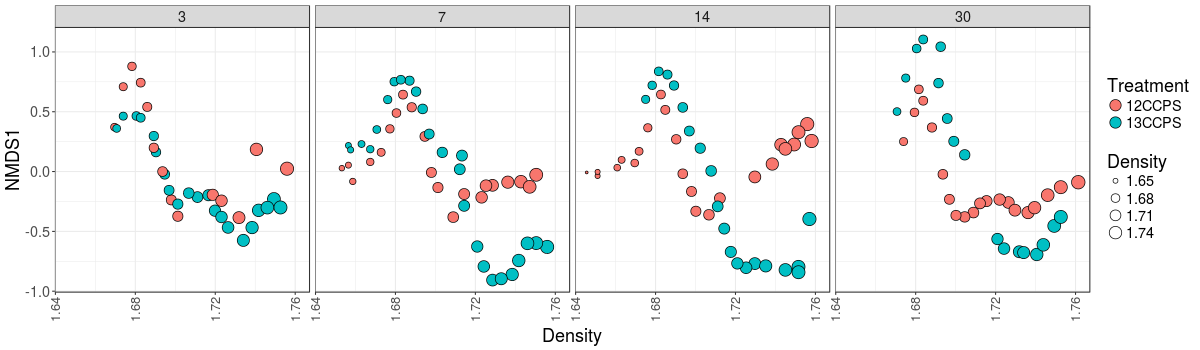

In [38]:
%%R -w 1200 -h 350

df = subset(df.plot, type == "sites")

df2 = df 
replaceFunction <- function(v){
   m <- as.numeric(v[1:2])
   if (v[11]=="30")
     out <- m * -1
   else
     out <- m
   return(out)
 }

 g <- apply(df2, 1, replaceFunction)
 df2[1:2] <- t(g)



asNum = function(x) as.numeric(as.character(x))

#p = ggplot(df, aes(x =Density, y = Axis.2, size = Density, fill = Treatment))
p = ggplot(df2, aes(x = Density, y = NMDS1, size = Density, fill = Treatment))
    
#labeli <- function(variable, value){
 # names_li <- list(3 ="Day 3", 7="Day 7", 14="Day 14", 30="Day 30")
  #return(names_li[value])}

p = p + facet_wrap(~Day, nrow = 1)

p = p + geom_point(shape = 21)

p = p + theme_bw() + theme(text = element_text(size=18), axis.text.x  = element_text(angle=90, vjust=0.5, size=13)) +
    guides(fill = guide_legend(override.aes = list(size=5)))
   
p

In [40]:
%%R
ggsave("data/figs/NMDS_by_day_Density.pdf",p, width = 12, height = 5)

### Adonis Stats

In [25]:
%%R
physeq.data = as(sample_data(physeq.fungi.thresh), "data.frame")
physeq.heavy = prune_samples((physeq.data$Density >= 1.7125), physeq.fungi.thresh)
physeq.heavy.data = as(sample_data(physeq.heavy), "data.frame")
physeq.a = prune_samples(!is.na(physeq.data$Density), physeq.fungi.thresh)
physeq.new = as(sample_data(physeq.a), "data.frame")
physeq.Day3  = prune_samples((physeq.data$Density >= 1.7125) & (physeq.data$Day == 3), physeq.fungi.thresh)
physeq.Day7 = prune_samples((physeq.data$Density >= 1.7125) & (physeq.data$Day == 7), physeq.fungi.thresh)
physeq.Day14 = prune_samples((physeq.data$Density >= 1.7125) & (physeq.data$Day == 14), physeq.fungi.thresh)
physeq.Day30 = prune_samples((physeq.data$Density >= 1.7125) & (physeq.data$Day == 30), physeq.fungi.thresh)
physeq.3.data = as(sample_data(physeq.Day3), "data.frame")
physeq.7.data = as(sample_data(physeq.Day7), "data.frame")
physeq.14.data = as(sample_data(physeq.Day14), "data.frame")
physeq.30.data = as(sample_data(physeq.Day30), "data.frame")

In [26]:
%%R 
adonis(iDist ~ Treatment, physeq.data)


Call:
adonis(formula = iDist ~ Treatment, data = physeq.data) 

Permutation: free
Number of permutations: 999

Terms added sequentially (first to last)

           Df SumsOfSqs MeanSqs F.Model      R2 Pr(>F)  
Treatment   1    0.4156 0.41564  3.4054 0.02084   0.02 *
Residuals 160   19.5289 0.12206         0.97916         
Total     161   19.9445                 1.00000         
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1


In [27]:
%%R 
adonis(iDist ~ Day, physeq.data)


Call:
adonis(formula = iDist ~ Day, data = physeq.data) 

Permutation: free
Number of permutations: 999

Terms added sequentially (first to last)

           Df SumsOfSqs MeanSqs F.Model      R2 Pr(>F)    
Day         1    2.5075 2.50749  23.008 0.12572  0.001 ***
Residuals 160   17.4370 0.10898         0.87428           
Total     161   19.9445                 1.00000           
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1


In [28]:
%%R
registerDoParallel(cores=20)
dist.heavy = distance(physeq.heavy, 
                      method = "bray",
                      fast = TRUE, 
                      parallel = TRUE, 
                      normalized = FALSE)

In [29]:
%%R 
adonis(dist.heavy ~ Treatment, physeq.heavy.data)


Call:
adonis(formula = dist.heavy ~ Treatment, data = physeq.heavy.data) 

Permutation: free
Number of permutations: 999

Terms added sequentially (first to last)

          Df SumsOfSqs MeanSqs F.Model      R2 Pr(>F)    
Treatment  1    0.8954 0.89545  10.657 0.13723  0.001 ***
Residuals 67    5.6297 0.08403         0.86277           
Total     68    6.5252                 1.00000           
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1


In [30]:
%%R 
adonis(dist.heavy ~ Day, physeq.heavy.data)


Call:
adonis(formula = dist.heavy ~ Day, data = physeq.heavy.data) 

Permutation: free
Number of permutations: 999

Terms added sequentially (first to last)

          Df SumsOfSqs MeanSqs F.Model      R2 Pr(>F)    
Day        1    1.5207 1.52074   20.36 0.23306  0.001 ***
Residuals 67    5.0044 0.07469         0.76694           
Total     68    6.5252                 1.00000           
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1


In [31]:
%%R
registerDoParallel(cores=20)
dist3 = distance(physeq.Day3, 
                      method = "bray", 
                      fast = TRUE, 
                      parallel = TRUE, 
                      normalized = FALSE)
dist7 = distance(physeq.Day7, 
                      method = "bray", 
                      fast = TRUE, 
                      parallel = TRUE, 
                      normalized = FALSE)
dist14 = distance(physeq.Day14, 
                      method = "bray", 
                      fast = TRUE, 
                      parallel = TRUE, 
                      normalized = FALSE)
dist30 = distance(physeq.Day30, 
                      method = "bray", 
                      fast = TRUE, 
                      parallel = TRUE, 
                      normalized = FALSE)

In [32]:
%%R 
adonis(dist3 ~ Treatment, physeq.3.data)


Call:
adonis(formula = dist3 ~ Treatment, data = physeq.3.data) 

Permutation: free
Number of permutations: 999

Terms added sequentially (first to last)

          Df SumsOfSqs MeanSqs F.Model      R2 Pr(>F)    
Treatment  1   0.43698 0.43698   11.96 0.47917  0.001 ***
Residuals 13   0.47497 0.03654         0.52083           
Total     14   0.91194                 1.00000           
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1


In [33]:
%%R 
adonis(dist7 ~ Treatment, physeq.7.data)


Call:
adonis(formula = dist7 ~ Treatment, data = physeq.7.data) 

Permutation: free
Number of permutations: 999

Terms added sequentially (first to last)

          Df SumsOfSqs MeanSqs F.Model      R2 Pr(>F)   
Treatment  1   0.43241 0.43241  13.473 0.44213  0.002 **
Residuals 17   0.54561 0.03209         0.55787          
Total     18   0.97802                 1.00000          
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1


In [34]:
%%R 
adonis(dist14 ~ Treatment, physeq.14.data)


Call:
adonis(formula = dist14 ~ Treatment, data = physeq.14.data) 

Permutation: free
Number of permutations: 999

Terms added sequentially (first to last)

          Df SumsOfSqs MeanSqs F.Model      R2 Pr(>F)    
Treatment  1   1.17492 1.17492  69.302 0.81243  0.001 ***
Residuals 16   0.27126 0.01695         0.18757           
Total     17   1.44618                 1.00000           
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1


In [35]:
%%R 
adonis(dist30 ~ Treatment, physeq.30.data)


Call:
adonis(formula = dist30 ~ Treatment, data = physeq.30.data) 

Permutation: free
Number of permutations: 999

Terms added sequentially (first to last)

          Df SumsOfSqs  MeanSqs F.Model      R2 Pr(>F)    
Treatment  1   0.29908 0.299082  18.269 0.54913  0.001 ***
Residuals 15   0.24557 0.016371         0.45087           
Total     16   0.54465                  1.00000           
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1


In [36]:
%%R -w 1200 -h 300
df2 = subset(df.plot, type == "sites")

asNum = function(x) as.numeric(as.character(x))

p3 = ggplot(df2, aes(x =Axis.1, y = Axis.2, size = Density, fill = Treatment))
#p = ggplot(df, aes(x = NMDS1, y = NMDS2, size = Density, fill = Treatment))

p3 = p3 + facet_wrap(~Day, nrow=1)

p3 = p3 + geom_point(shape = 21)

p3 = p3 + theme_bw()
    
p3 = p3 + theme(text = element_text(size=18)) 
    
p3

/opt/anaconda2/lib/python2.7/site-packages/rpy2/rinterface/__init__.py:186: RRuntimeWarning: Error in eval(expr, envir, enclos) : object 'Axis.1' not found

  warnings.warn(x, RRuntimeWarning)


RRuntimeError: Error in eval(expr, envir, enclos) : object 'Axis.1' not found


In [ ]:
%%R -w 1200 -h 300

getPalette = colorRampPalette(brewer.pal(9, "Set1"))
#getPalette2= colorRampPalette(brewer.pal(8, "Dark2"))
#cmap1 = b2m.get_map("Set1", "qualitative", 9)
#cmap2 = b2m.get_map("Dark2", "qualitative", 7)
#cmap3 = b2m.get_map("Set2", "qualitative", 8)
#colors = c(getPalette,getPalette2)

p2 = ggplot(df.plot, aes(x = Axis.1, y = Axis.2, color = Rank3)) 

p2 = p2 + facet_grid(. ~ Day)

p2 = p2 + geom_point(alpha = 1, size = 1.5, shape = 21)

p2 = p2 + scale_color_manual(values=getPalette(15))

p2 = p2 + guides(color = guide_legend(override.aes = list(size = 4), label.position = "right"))

p2 = p2 + theme_bw()

p.otus = p2

p2

In [ ]:
%%R -w 1200 -h 600

p.total = grid.arrange (p3, p2, ncol = 1, nrow = 2)


In [ ]:
%%R -w 1200 -h 800
pdf("data/figs/PCoA_by_day_OTUs.pdf", width = 14, height = 8)
grid.arrange(p3, p2, ncol=1, nrow=2)
dev.off()

In [ ]:
FileLink("data/figs/PCoA_by_day_OTUs.pdf")

In [ ]:
%%R -w 1200 -h 300

days = list(day3=3, day7=7, day14=14, day30=30)

md = sample_data(physeq.fungi.thresh)

ord = function(x) {
    ps = prune_samples((md$Day == x)&(md$SampleID != "D312.6"), physeq.fungi.thresh)
    pcoa = ordinate(ps, 
                method = "NMDS", 
                distance = "bray")
    p.pcoa = plot_ordination(ps, pcoa, justDF = TRUE)
    return(p.pcoa)
}

df = ldply(days, ord)

df$.id = factor(df$.id, levels= c("day3", "day7", "day14", "day30"))

#p = ggplot(df, aes(x = Density, y = Axis.1, size = Density, fill = Treatment))
p = ggplot(df, aes(x = NMDS1, y = NMDS2, size = Density, fill = Treatment))

p = p + facet_wrap(~.id, nrow = 1, scales = "free")

p = p + geom_point(shape = 21)

p = p + theme_bw()

p

In [ ]:
%%R
d = subset(df, Day == 3)
d[order(-d$NMDS1),]